# Greedy query strategies


[Labeling a single sample per iteration](../single/accuract.ipynb) is a great way to train a model very cost efficient, even with imbalanced data. In practice however an annotator prefers to label a batch samples instead of a single sample.

Even with balanced data this already has downsides:
- Since all n samples are selected based on the same state of the model, they will not benefit from the info gained from the other samples in the same batch.
- The learner might pick samples that give more or less the same information. This may result in gaining very few new info, while having ladled a lot of samples.

There are 2 mayor ways of dealing with these problems.
- 1. [Greedy query strategy](./greedy.ipynb)
- 2. [Batch aware query strategy](./batch_aware.ipynb)

We will look into both approaches and how they deal with imbalanced data.

These strategies don't care what other samples have been picked. Just pick the top-K samples with the best score.

In [1]:
#imports
import numpy as np

# matplotlib
import matplotlib.pyplot as plt

# tensorflow
import tensorflow as tf

# sklearn
from skactiveml.classifier import SklearnClassifier
from skactiveml.pool import UncertaintySampling, BatchBALD
from skactiveml.utils import MISSING_LABEL

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import LabelBinarizer
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

# balanced accuracy
from balanced_accuracy import balanced_accuracy

# warnings
import warnings
warnings.filterwarnings("ignore")

# https://stackoverflow.com/questions/8391411/how-to-block-calls-to-print
import sys, os
# Disable
def blockPrint():
    sys.stdout = open(os.devnull, 'w')

# Restore
def enablePrint():
    sys.stdout = sys.__stdout__

tf.get_logger().setLevel(tf.compat.v1.logging.ERROR)

2023-11-26 01:50:02.682466: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-26 01:50:02.729575: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-26 01:50:02.729620: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-26 01:50:02.730975: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-26 01:50:02.738202: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-26 01:50:02.738931: I tensorflow/core/platform/cpu_feature_guard.cc:1

## Uncertainty-based strategy

The first method is uncertainty-based. We will use a dropout turned on bayesian neural network as classifier. Given this clf we will compute.
$$
P(y|x) \approx \frac{1}{T} \sum_{t=1}^T \hat{P}(y|x, drop_t)
$$
This probability will then be used by the uncertainty query algorithm to pick the top k samples.

In [2]:
# Use tensor flow to create the network, wrap it with sklearn
class DropoutBNN(BaseEstimator, ClassifierMixin):
    def __init__(self, hidden_layers_sizes=(10,), dropout_rate=0.5, learning_rate=0.001, epochs=10, T=10):
        self.hidden_layers_sizes = hidden_layers_sizes
        self.dropout_rate = dropout_rate
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.T = T

    def build_model(self, input_dim, num_classes):
        model = tf.keras.Sequential()
        # create input layer
        model.add(tf.keras.layers.Input(shape=(input_dim,)))

        # create hidden layer with dropout
        for layer_size in self.hidden_layers_sizes:
            model.add(tf.keras.layers.Dense(layer_size, activation='relu'))
            model.add(tf.keras.layers.Dropout(self.dropout_rate))

        # create output layer
        model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        return model

    def fit(self, X, y):
        # needed for the skactiveml wrapper
        self.classes_ = np.unique(y)

        self.input_dim = X.shape[1]
        self.num_classes = len(np.unique(y))

        self.lb = LabelBinarizer()
        y_one_hot = self.lb.fit_transform(y) 

        # create model and fit
        self.model = self.build_model(self.input_dim, self.num_classes)
        self.model.fit(X, y_one_hot, epochs=self.epochs, verbose=0)

    def predict_proba(self, X):
        # predict T times and get mean
        prob_sum = np.zeros((X.shape[0], self.num_classes))

        for _ in range(self.T):
            prob_sum += self.model.predict(X)

        return prob_sum / self.T

    def predict(self, X):
        # get probailities, return most likely label
        predictions = self.predict_proba(X)
        return np.argmax(predictions, axis=1)

    def score(self, X, y):
        # compare predicted labels with actual labels
        predictions = self.predict(X)
        return np.mean(np.array(predictions) == np.array(y)) 

In [3]:
# Use tensor flow to create the network, wrap it with sklearn
class BNN(BaseEstimator, ClassifierMixin):
    def __init__(self, T=10, **MLPkwargs):
        self.T = T
        self.clf = MLPClassifier(**MLPkwargs)

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        self.clf.fit(X, y)

    def predict_proba(self, X):
        # predict T times and get mean
        prob_sum = np.zeros((X.shape[0], len(self.classes_)))
        for _ in range(self.T):
            print(self.clf.predict(X))

        return prob_sum / self.T

    def predict(self, X):
        # get probailities, return most likely label
        predictions = self.predict_proba(X)
        return np.argmax(predictions, axis=1)

    def score(self, X, y):
        # compare predicted labels with actual labels
        predictions = self.predict(X)
        return balanced_accuracy(y, predictions)

In [4]:
# using skactiveml bald

def al_batch(iterations=1, batch_size=1, weights = [0.8,0.2], data_size=150, query_count=10):
    data = []
    qs = UncertaintySampling(method='entropy')
    for rand in range(iterations):
        # Create the data
        X, y = make_classification(n_samples=data_size*4, n_features=2, n_redundant=0, weights=weights, random_state=rand)
        Xf, Xt, yf, yt = train_test_split(X, y, random_state=rand);
        y = np.full(shape=yf.shape, fill_value=MISSING_LABEL)

        clf = SklearnClassifier(LogisticRegression(), classes=np.unique(yf))
        clf.fit(Xf, y)
        out = []
        for _ in range(query_count):
            query_idx = qs.query(Xf, y, clf=clf, batch_size=batch_size)
            y[query_idx] = yf[query_idx]
            clf.fit(Xf, y)
            y_predict = clf.predict(Xt)
            out.append(balanced_accuracy(yt, y_predict))
        data.append(out)
    return np.mean(np.array(data), axis=0)
        

In [5]:
# using skactiveml bald

def al_bald(iterations=1, batch_size=1, weights = [0.8,0.2], data_size=150, query_count=10):
    data = []
    qs = BatchBALD()
    for rand in range(iterations):
        # Create the data
        X, y = make_classification(n_samples=data_size*4, n_features=2, n_redundant=0, weights=weights, random_state=rand)
        Xf, Xt, yf, yt = train_test_split(X, y, random_state=rand);
        y = np.full(shape=yf.shape, fill_value=MISSING_LABEL)
        ensemble = []
        ensemble.append(SklearnClassifier(LogisticRegression(), classes=np.unique(yf)))
        for clf in ensemble:
            clf.fit(Xf, y)
        out = []
        for _ in range(query_count):
            query_idx = qs.query(Xf, y, ensemble=ensemble, batch_size=batch_size)
            y[query_idx] = yf[query_idx]

            mean =0
            for clf in ensemble:
                clf.fit(Xf, y)

                y_predict = clf.predict(Xt)
                mean += balanced_accuracy(yt, y_predict)
            out.append(mean / len(ensemble))
        data.append(out)
    return np.mean(np.array(data), axis=0)

In [6]:
batch_size = 50
data_size = 100000
query_count = 10

In [7]:
# large data set bald
bald_data = al_bald(iterations=1, batch_size=batch_size, data_size=data_size, query_count=query_count)

In [8]:
# large data set uncertainty sampling
batch_data = al_batch(iterations=1, batch_size=batch_size, data_size=data_size, query_count=query_count)

In [9]:
# large balanced data set uncertainty sampling
batch_data_bal = al_batch(iterations=1, batch_size=batch_size, data_size=data_size, query_count=query_count, weights=None)

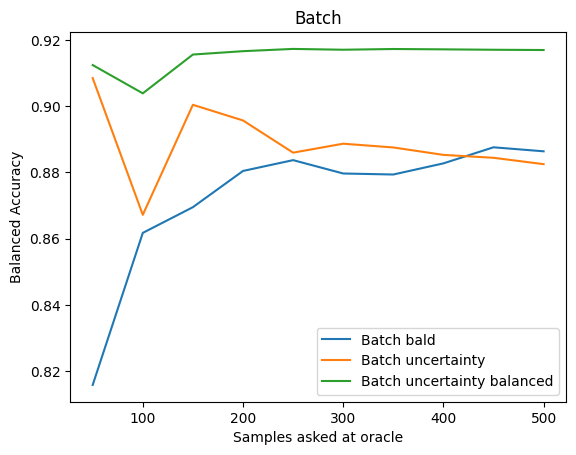

In [10]:
x = []
for i in range(1, len(batch_data)+1):
    x.append(i*batch_size)


plt.plot(x, bald_data, label=f'Batch bald')
plt.plot(x, batch_data, label=f'Batch uncertainty')
plt.plot(x, batch_data_bal, label=f'Batch uncertainty balanced')

plt.legend()
plt.xlabel('Samples asked at oracle')
plt.ylabel('Balanced Accuracy')
plt.title('Batch')
plt.show()


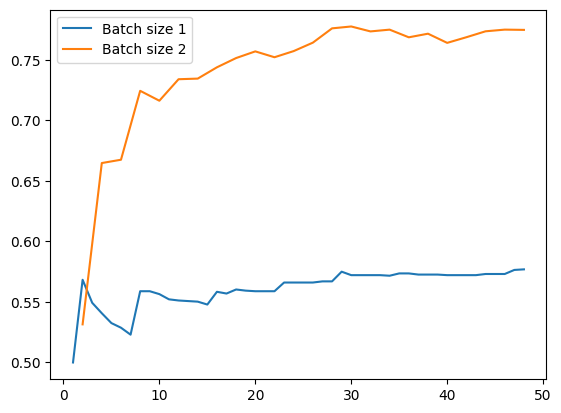

In [11]:
for exp in range(2):
    batch_size = 2**exp
    data = al_bald(iterations=5, batch_size=batch_size, data_size=1000, query_count=int(48/batch_size))
    x = []
    for i in range(1, len(data)+1):
        x.append(i*batch_size)
    plt.plot(x, data, label=f'Batch size {batch_size}')
plt.legend()


In [12]:
data = al_bald(iterations=5, batch_size=5, data_size=1000, query_count=20)

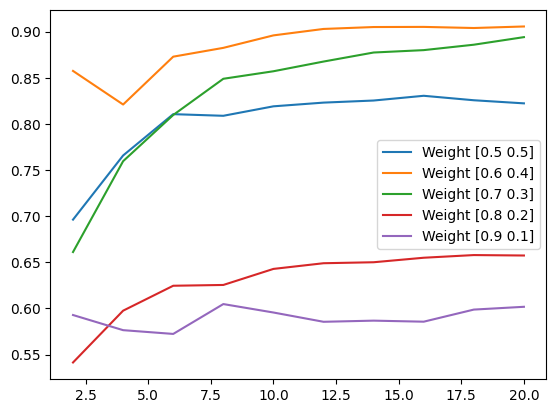

In [13]:
for skew in np.arange(0.5, 1, 0.1):
    weight =  np.around([skew, 1-skew], decimals=1)
    data = al_bald(iterations=5, batch_size=5, weights=weight, data_size=1000, query_count=10)
    x = []
    for i in range(1, len(data)+1):
        x.append(i*batch_size)
    plt.plot(x, data, label=f'Weight {weight}')

plt.legend()
